<a href="https://colab.research.google.com/github/wikiviggy/Algorithm-Implementation-Using-Map-Reduce/blob/master/chest_XRAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone https://github.com/wikiviggy/Visiondataset.git

Cloning into 'Visiondataset'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (368/368), done.
remote: Total 368 (delta 0), reused 368 (delta 0), pack-reused 0
Receiving objects: 100% (368/368), 61.87 MiB | 41.60 MiB/s, done.


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 512.6MB 33.3MB/s 
    100% |████████████████████████████████| 2.0MB 12.6MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
import torchvision 
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets , models , transforms 
from torch.optim import lr_scheduler 
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import os 
import copy 


In [0]:
# As VGG16 requires the data in certain form so ,we are transforming the data as per required(normalization)
train_datatransform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485 , 0.456 ,0.406] ,[0.229 , 0.224 , 0.225])])
test_datatrannsform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(), 
                                         transforms.Normalize([0.485 ,0.456 ,0.406] ,[0.229 , 0.224 ,0.225])])

In [0]:
#Yeah , we need to export the data that we have created 
train_image_dataset = datasets.ImageFolder(root='./Visiondataset/train',transform=train_datatransform )
test_image_dataset = datasets.ImageFolder(root ='./Visiondataset/test', transform=test_datatrannsform)

In [0]:
#DataLoader - Load the train and test data in the form of batches

train_dataloader = torch.utils.data.DataLoader(train_image_dataset , batch_size =4 ,shuffle=True , num_workers=4 )
test_dataloader = torch.utils.data.DataLoader(test_image_dataset , batch_size = 4 , shuffle= True , num_workers=4)

In [0]:
class_names = train_image_dataset.classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['cardiomegaly', 'normal', 'opacity']
cuda:0


In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL

    100% |████████████████████████████████| 5.6MB 8.5MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


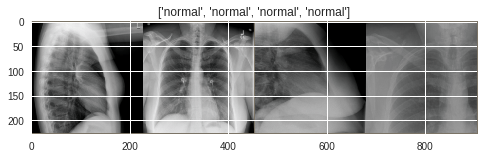

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [0]:
def train_model(model , criterion , optimizer , scheduler ,num_epochs):
  since =time.time()
  best_acc =0.0
  best_model_wts = copy.deepcopy(model.state_dict())
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch , num_epochs -1))
    print('-'*10)
    
    scheduler.step()
    model.train()
    
    running_loss = 0.0 
    running_corrects = 0
    
    for inputs , labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = model(inputs)
      _, preds = torch.max(outputs , 1)
      loss = criterion(outputs , labels)
      
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() *inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      
    epoch_loss = running_loss / len(train_image_dataset)
    epoch_acc = running_corrects.double() / len(train_image_dataset)
    
    print('Loss : {}  Acc :{}'.format(epoch_loss , epoch_acc))
    
    if epoch_acc > best_acc:
      best_acc =epoch_acc 
      best_model_wts = copy.deepcopy(model.state_dict())
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    
    
  model.load_state_dict(best_model_wts)
  return model
  

In [0]:
def set_require_grad(model , feature_extract):
  if feature_extract:
    for param in model.parameters():
      param.require_grad=False

In [0]:
#VGG16
model_ft = models.vgg16_bn(pretrained =True)
set_require_grad(model_ft,False)
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters() , lr = 0.0015 , momentum =0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size =7 ,gamma=0.1)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:27<00:00, 20237733.25it/s]


In [0]:
#DENSENET 161
model_dn  = models.densenet161(pretrained=True)
set_require_grad(model_dn,False)
features = list(model_dn.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(2208, len(class_names))]) # Add our layer with 4 outputs
model_dn.classifier = nn.Sequential(*features)

model_dn = model_dn.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_dn = optim.SGD(model_dn.parameters() , lr = 0.001 , momentum =0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dn,step_size = 7 ,gamma=0.1)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
#RESNET 50
model_res = models.resnet50(pretrained=True)
set_require_grad(model_res,False)
features = list(model_res.children())[:-1] # Remove last layer
features.extend([nn.Linear(2048, len(class_names))]) # Add our layer with 4 outputs
model_res.classifier = nn.Sequential(*features)

model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_res = optim.SGD(model_res.parameters() , lr = 0.001 , momentum =0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dn,step_size = 7 ,gamma=0.1)

In [0]:
#VGG16
model_ft = train_model(model_ft , criterion , optimizer_ft , exp_lr_scheduler , num_epochs = 25)

Epoch 0/24
----------
Loss : 0.7688624449523098  Acc :0.7650602409638555
Epoch 1/24
----------
Loss : 0.6878278057977377  Acc :0.7891566265060241
Epoch 2/24
----------
Loss : 0.6396832855710064  Acc :0.7771084337349398
Epoch 3/24
----------
Loss : 0.665283992168415  Acc :0.7740963855421688
Epoch 4/24
----------
Loss : 0.6271572516984251  Acc :0.783132530120482
Epoch 5/24
----------
Loss : 0.6122978941862842  Acc :0.7710843373493976
Epoch 6/24
----------
Loss : 0.5887028745499002  Acc :0.7891566265060241
Epoch 7/24
----------
Loss : 0.6312335347195706  Acc :0.7771084337349398
Epoch 8/24
----------
Loss : 0.5676433402730758  Acc :0.7891566265060241
Epoch 9/24
----------
Loss : 0.58322896081281  Acc :0.7740963855421688
Epoch 10/24
----------
Loss : 0.5713039232664797  Acc :0.783132530120482
Epoch 11/24
----------
Loss : 0.5514876338013683  Acc :0.7951807228915663
Epoch 12/24
----------
Loss : 0.5679100017590695  Acc :0.7981927710843374
Epoch 13/24
----------
Loss : 0.553659117724522  Acc 

In [0]:
#DENSENET 161
model_dn = train_model(model_dn , criterion , optimizer_dn , exp_lr_scheduler , num_epochs = 25)

Epoch 0/24
----------
Loss : 0.7501655195850924  Acc :0.7740963855421688
Epoch 1/24
----------
Loss : 0.679053964026003  Acc :0.7650602409638555
Epoch 2/24
----------
Loss : 0.696781188249588  Acc :0.7349397590361446
Epoch 3/24
----------
Loss : 0.6732691869319204  Acc :0.746987951807229
Epoch 4/24
----------
Loss : 0.7237335991069495  Acc :0.7680722891566265
Epoch 5/24
----------
Loss : 0.715015953204718  Acc :0.7349397590361446
Epoch 6/24
----------
Loss : 0.6471052460641746  Acc :0.7680722891566265
Epoch 7/24
----------
Loss : 0.5857906539038004  Acc :0.786144578313253
Epoch 8/24
----------
Loss : 0.5396403677492256  Acc :0.7801204819277109
Epoch 9/24
----------
Loss : 0.545869196933436  Acc :0.8132530120481928
Epoch 10/24
----------
Loss : 0.5354173339634056  Acc :0.8162650602409639
Epoch 11/24
----------
Loss : 0.5099552995469196  Acc :0.8162650602409639
Epoch 12/24
----------
Loss : 0.47120892750211507  Acc :0.8102409638554218
Epoch 13/24
----------
Loss : 0.5069971405957119  Acc

In [0]:
#RESNET 50
model_res = train_model(model_res , criterion , optimizer_res , exp_lr_scheduler , num_epochs = 25)

Epoch 0/24
----------
Loss : 1.9064608180379292  Acc :0.674698795180723
Epoch 1/24
----------
Loss : 0.960871636149395  Acc :0.7048192771084337
Epoch 2/24
----------
Loss : 0.8031522768089571  Acc :0.7439759036144579
Epoch 3/24
----------
Loss : 0.7542436381420458  Acc :0.746987951807229
Epoch 4/24
----------
Loss : 0.7173289074955216  Acc :0.75
Epoch 5/24
----------
Loss : 0.7211897775351283  Acc :0.7560240963855422
Epoch 6/24
----------
Loss : 0.7292838182794043  Acc :0.7801204819277109
Epoch 7/24
----------
Loss : 0.7577375661895935  Acc :0.7439759036144579
Epoch 8/24
----------
Loss : 0.7005782974771706  Acc :0.7650602409638555
Epoch 9/24
----------
Loss : 0.6947558385780058  Acc :0.7620481927710844
Epoch 10/24
----------
Loss : 0.6525001612054296  Acc :0.7891566265060241
Epoch 11/24
----------
Loss : 0.6603074475943324  Acc :0.7740963855421688
Epoch 12/24
----------
Loss : 0.6651830931743944  Acc :0.783132530120482
Epoch 13/24
----------
Loss : 0.627131456352142  Acc :0.7861445783

In [0]:
def eval_model(model , criterion):
  
  model.eval()
  
  running_loss = 0.0 
  running_corrects = 0
  
  for inputs , labels in test_dataloader :
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs , labels)
    
    running_loss += loss.item() *inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  
        
  loss = running_loss / len(test_image_dataset)
  acc = running_corrects.double() / len(test_image_dataset)
    
  print('Loss : {}  Acc :{}'.format(loss , acc))
    
 

In [0]:
#VGG16 Test accuracy
eval_model(model_ft , criterion)

Loss : 1.079731626170022  Acc :0.6428571428571428


In [0]:
#DENSENET Test accuracy
eval_model(model_dn , criterion)

Loss : 1.312148426260267  Acc :0.42857142857142855


In [0]:
#RESNET 50
eval_model(model_res , criterion)


Loss : 1.4166157586233956  Acc :0.5


In [0]:
torch.save(model_res, 'model_resnet.h5')

In [0]:
torch.save(model_dn, 'model_densenet.h5')

In [0]:

model = torch.load('model_resnet.h5')

In [0]:

model = torch.load('model_densenet.h5')

In [0]:

criterion = nn.CrossEntropyLoss()
eval_model(model , criterion)

Loss : 1.441195969070707  Acc :0.5


Actual labels are: ['opacity', 'normal', 'normal', 'cardiomegaly']
Predictions are: ['normal', 'normal', 'normal', 'cardiomegaly']


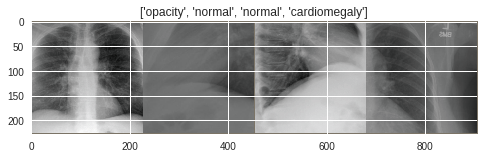

In [0]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))
out = torchvision.utils.make_grid(inputs)
l = [class_names[x] for x in classes]
print("Actual labels are:" , l) #actual

inputs = inputs.to(device)
classes = classes.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs,1)
p = [class_names[x] for x in preds]

print("Predictions are:", p) #prediction
loss = criterion(outputs , classes)
imshow(out, title=l)